## The Effects of Lifestyle Based Variables on the Math Grades of Students
### Introduction:
provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
clearly state the question you tried to answer with your project
identify and describe the dataset that was used to answer the question
### Methods & Results:
describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
your report should include code which:
loads data from the original source on the web 
wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
performs the data analysis
creates a visualization of the analysis 
note: all tables and figure should have a figure/table number and a legend
### Discussion:
summarize what you found
discuss whether this is what you expected to find?
discuss what impact could such findings have?
discuss what future questions could this lead to?
### References
At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
Make sure to cite the source of your data as well.


### Introduction

This group will be examining factors influencing student performance in Portuguese secondary students to attempt to answer the question of which factor is most influential in promoting good grades. We will be approaching this problem using classification techniques in R. The student achievement data was collected from 2 Portuguese secondary schools and assessed performance in mathematics. The data includes the target variable (student grades during periods 1, 2, and 3) in addition to 30 predictor variables. For the purposes of this project, we have chosen 3 variables with numerical values to be able to determine the answer to our question. The 3 variables are hours of free time, hours of study time, and number of school absences. Moreover, the data originally comes in an excel sheet format which will need to be considered when reading the data set into R. The data can be accessed through the link below Data set: https://archive.ics.uci.edu/dataset/320/student+performance Data set source: UC Irvine Machine Learning Repository

### Reading in the Data

Here, we read in the data from our GitHub repository. The original dataset is from the UC Irvine Machine Learning Repository, but for reproducibility, we will read it in from a GitHub URL. This is what we have done below, using `read_csv2` to read in the data, as it uses a semi-colon as a delimiter. We use `head` to display the first 6 lines of our dataset.

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('tests.R')
source('cleanup.R')

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [3]:
url <- "https://raw.githubusercontent.com/chloezandberg/dsci-100-project/main/student-mat.csv"
math_data <- read_csv2(url)
head(math_data)

ℹ Using "','" as decimal and "'.'" as grouping mark. Use `read_delim()` for more control.

Rows: 395 Columns: 33
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (17): school, sex, address, famsize, Pstatus, Mjob, Fjob, reason, guardi...
dbl (16): age, Medu, Fedu, traveltime, studytime, failures, famrel, freetime...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,4,3,4,1,1,3,6,5,6,6
GP,F,17,U,GT3,T,1,1,at_home,other,⋯,5,3,3,1,1,3,4,5,5,6
GP,F,15,U,LE3,T,1,1,at_home,other,⋯,4,3,2,2,3,3,10,7,8,10
GP,F,15,U,GT3,T,4,2,health,services,⋯,3,2,2,1,1,5,2,15,14,15
GP,F,16,U,GT3,T,3,3,other,other,⋯,4,3,2,1,2,5,4,6,10,10
GP,M,16,U,LE3,T,4,3,services,other,⋯,5,4,2,1,2,5,10,15,15,15


### Wrangling the Data

Below, we clean the data by selecting only the predictor variables that we will use in our classification problem, `freetime`, `studytime`, and `absences`, and the variable we intend to predict, `G3`. For context, G3 is the final grade in the Portuguese school system. Next, we calculate `G3` as a percentage (as G3 is reported out of 20 in the Portuguese school system). Finally, we recoded the final grade percentages according to the UBC grading scheme to be letter grades for our classification problem. We use `head` to display the first six rows of our clean data.

In [4]:
clean_math_data <- math_data |>
    select(freetime, studytime, absences, G3) |> # G3 is final grade in Portugese school system
    mutate(final_percentage = (G3/20)*100) |> # final grade is out of 20
    mutate(letter_grade = cut(final_percentage, c(-1, 49, 54, 67, 79, 100))) |> # recoding to be letter grade levels for classification problem
    mutate(letter_grade = recode(letter_grade,                                  # had to set lower limit to -1 to include grades of 0%
                                           "(-1,49]" = "F",
                                           "(49,54]" = "D",
                                           "(54,67]" = "C",
                                           "(67,79]" = "B",
                                           "(79,100]" = "A")) |> 
    select(freetime, studytime, absences, letter_grade) |>
    drop_na()
                                           
head(clean_math_data)

freetime,studytime,absences,letter_grade
<dbl>,<dbl>,<dbl>,<fct>
3,2,6,F
3,2,4,F
3,2,10,D
2,3,2,B
3,2,4,D
4,2,10,B


### Exploratory Data Analysis

Below, we explore our clean dataset by counting up how many students received each letter grade. We do this by grouping our dataset by letter grade (`letter_grade`), using `group_by`. Then, we use `summarize` to count the number of rows (or observations) of each letter grade to get their respective counts. We also explore our data by finding the average of each predictor variable using `map_df`, and renaming each column to reflect this. Finally, we cont up the total number of observations in our dataset and report this with the average of each predictor.

In [6]:
avg_predictors <- clean_math_data |>
            select(freetime, studytime, absences) |>
            map_df(mean) |>
            rename("avg_freetime" = "freetime", # renaming each column to reflect that each column is now the average of each predictor variable
                   'avg_studytime' = 'studytime',
                   'avg_absences' = 'absences')

count_observations <- nrow(clean_math_data) # counting number of observations in the dataset

count_class <- clean_math_data |>
            group_by(letter_grade) |>
            summarize(count = n()) # counting how many instances occur of each letter grade, grouped by letter_grade

count_class

observations_tibble <- tibble(number_observations = count_observations)

exploratory_data_analysis <- bind_cols(observations_tibble, avg_predictors) # binding the total number of observations with the average of each predictor

exploratory_data_analysis

letter_grade,count
<fct>,<int>
F,130
D,56
C,109
B,60
A,40


number_observations,avg_freetime,avg_studytime,avg_absences
<int>,<dbl>,<dbl>,<dbl>
395,3.235443,2.035443,5.708861


### Visualizing the Data

Below, we create several visualizations to get a sense of what our data looks like prior to our analysis. First, we create `math_plot` which is a bar chart that helps us investigate which of the final grades are most common of the 5 (A, B, C, D, and F). Next, we create `absences_dist` which is a bar chart that helps us investigate what the distribution of absences look like for students. After this, we create `freetime_dist` which plots the distribution of each level of free time a student has (on a scale from 1-4). Finally, we create `studytime_dist` which plots the distribution of the amount of study time each student has.

Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


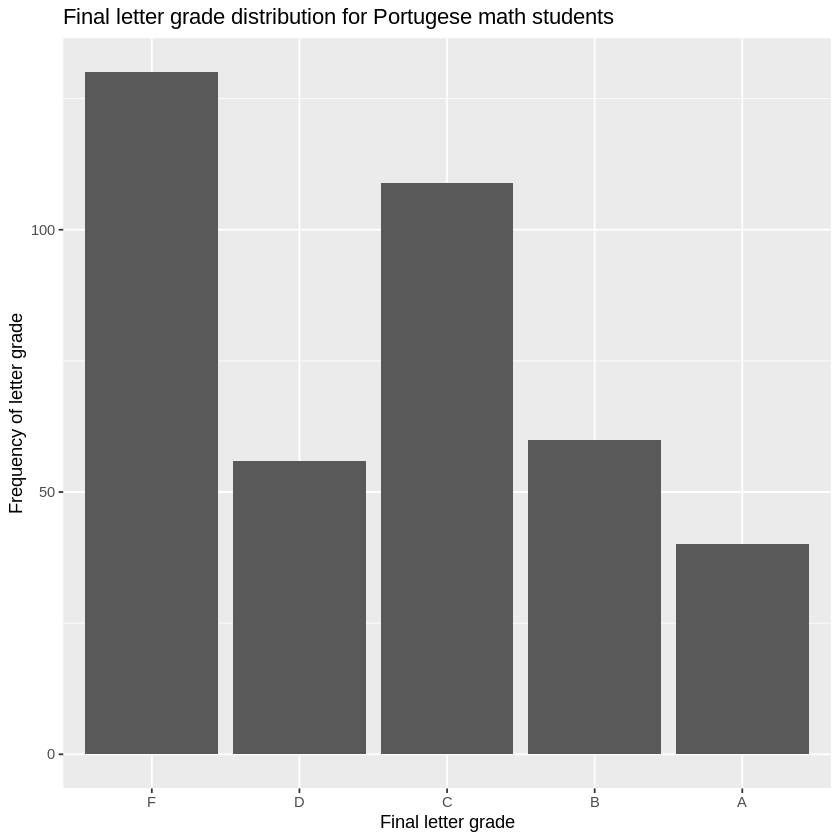

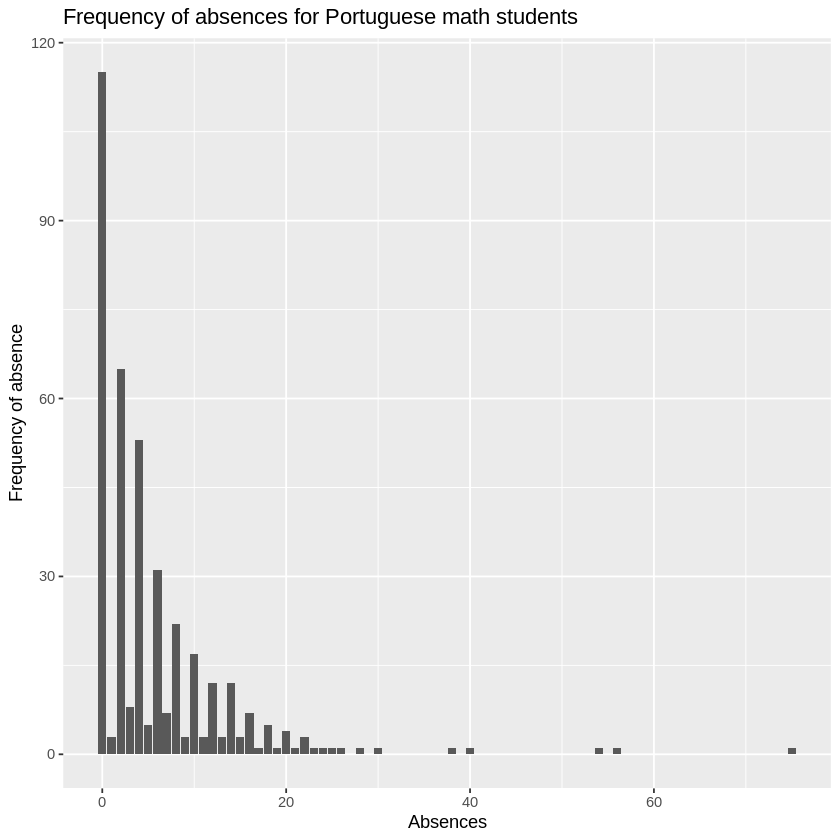

In [ ]:
math_plot <- ggplot(clean_math_data, aes(x=letter_grade)) +
                geom_histogram(stat='count') +
                labs(x="Final letter grade",
                y="Frequency of letter grade") +
                ggtitle("Final letter grade distribution for Portugese math students") # investigate which grades are most common

absences_dist <- ggplot(clean_math_data, aes(x=absences)) + #  number of school absences (numeric: from 0 to 93)
                    geom_histogram(stat='count') +
                    labs(x='Absences',
                         y='Frequency of absence') +
                        ggtitle('Frequency of absences for Portuguese math students')

freetime_dist <- ggplot(clean_math_data, aes(x=freetime)) + # free time after school (numeric: from 1 - very low to 5 - very high)
                    geom_bar(stat='count') +
                    labs(x='Free time (1-5)',
                         y='Frequency of free time level') +
                        ggtitle('Frequency of free time level for Portuguese math students')

studytime_dist <- ggplot(clean_math_data, aes(x=studytime)) + # weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
                    geom_bar(stat='count') +
                    labs(x='Study time (1-4)',
                         y='Frequency of study time level') +
                        ggtitle('Frequency of study time level for Portuguese math students')

math_plot
absences_dist
freetime_dist
studytime_dist